In [1]:
from pynq.overlays.h264 import H264Overlay
from pynq.lib.video import *

base = H264Overlay("h264.bit")
hdmi_in = base.video.hdmi_in

load ready


In [2]:
hdmi_in.configure(pixelformat=PIXEL_RGBA)
hdmi_in.start()

## repeat from here

In [3]:
cma_send = hdmi_in.readframe()

In [4]:
# cma_send.tofile("infile")

In [5]:
from pynq import Xlnk
xlnk = Xlnk()

cma_recv = xlnk.cma_array([cma_send.size,], dtype=np.uint8)

# RGB32->YUV转码

In [7]:
from pynq import MMIO

rgb2yuv = MMIO(base.ip_dict['h264/rgb2yuv_with_axi_0']['phys_addr'], 0x10000)

In [8]:
rgb2yuv.write(0x04, cma_send.physical_address)
rgb2yuv.write(0x08, cma_recv.physical_address)
rgb2yuv.write(0x0c, 1088)
rgb2yuv.write(0x10, 1920)
rgb2yuv.write(0x14, 1920*1088)
rgb2yuv.write(0x00, 1)
rgb2yuv.write(0x00, 0)

In [9]:
cma_recv[:int(1920*1088*1.5)].tofile("yuv420.in")

# h264压缩

In [10]:
from pynq import MMIO

h264 = MMIO(base.ip_dict['h264/h264enc_with_axi_0']['phys_addr'], 0x10000)
result = xlnk.cma_array((cma_send.size,), dtype=np.uint8)

In [11]:
h264.write(0x04, 0x00004377) # length 1088*1920
h264.write(0x08, 0)
h264.write(0x14, cma_recv.physical_address)
h264.write(0x18, result.physical_address)
h264.write(0x00, 1)

In [12]:
h264_size = h264.read(0x1c)
h264_size

137034

In [13]:
# result[:h264_size].tofile("final")

# send to VLC

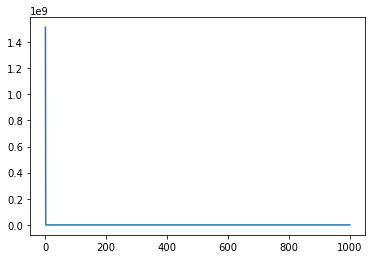

In [17]:
%matplotlib inline
from h264py.h264 import H264
h264 = H264()
start = time.time()
arr = [start]
for i in range(1000):
    h264.send_frame(result[:h264_size])
    arr.append(time.time()-start)
    start = time.time()
from matplotlib import pyplot as plt
plt.plot(arr)
plt.show()

# free

In [13]:
hdmi_in.stop()
xlnk.xlnk_reset()

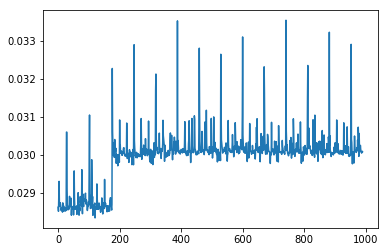

In [18]:
plt.plot(arr[10:])
plt.show()